In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from matplotlib.collections import LineCollection
from sklearn.metrics import RocCurveDisplay
from pycaret.anomaly import *
from sklearn.preprocessing import MinMaxScaler

In [91]:
ics_entropy = pd.read_csv('ics_entropy.csv')
col = ics_entropy.columns
ics_entropy = ics_entropy.to_numpy()
attack_entropy = pd.read_csv('ics_attack.csv').to_numpy()

In [85]:
def smoothListGaussian(list, degree=5):
    window = degree*2-1
    weight = np.array([1.0]*window)
    weightGauss = []
    for i in range(window):
        i = i-degree+1
        frac = i/float(window)
        gauss = 1/(np.exp((4*(frac))**2))
        weightGauss.append(gauss)
    weight = np.array(weightGauss)*weight
    smoothed = [0.0]*(len(list)-window)
    for i in range(len(smoothed)):
        smoothed[i] = sum(np.array(list[i:i+window])*weight)/sum(weight)
    return smoothed

In [94]:
attack_time = np.asarray(np.where(attack_entropy[:,1] == 1))[0]
print(attack_time.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
ics_entropy[:,1:] = scaler.fit_transform(ics_entropy[:,1:])
# smooth_ics = np.zeros((19624,18))

# for i in range(1,18):
#     smooth_ics[:,i] = smoothListGaussian(ics_entropy[:,i])
            

(1009,)


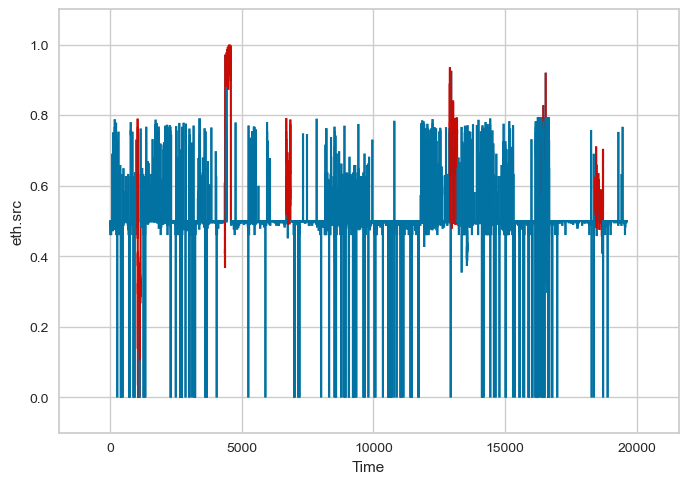

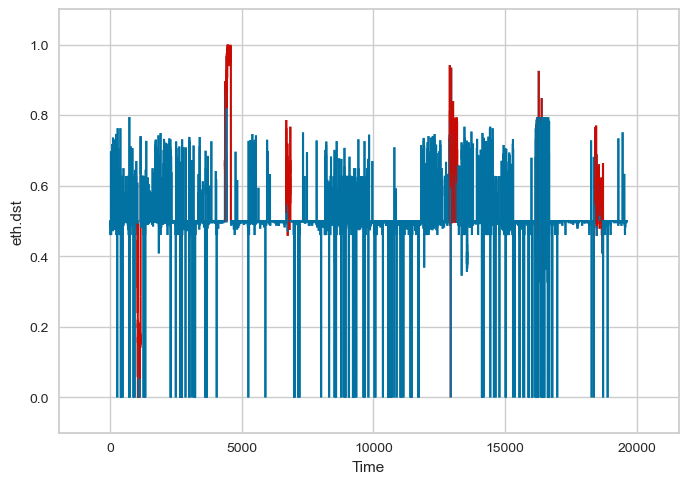

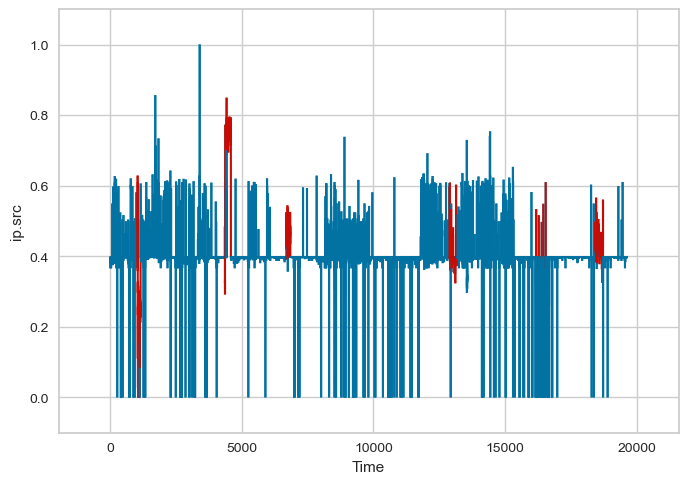

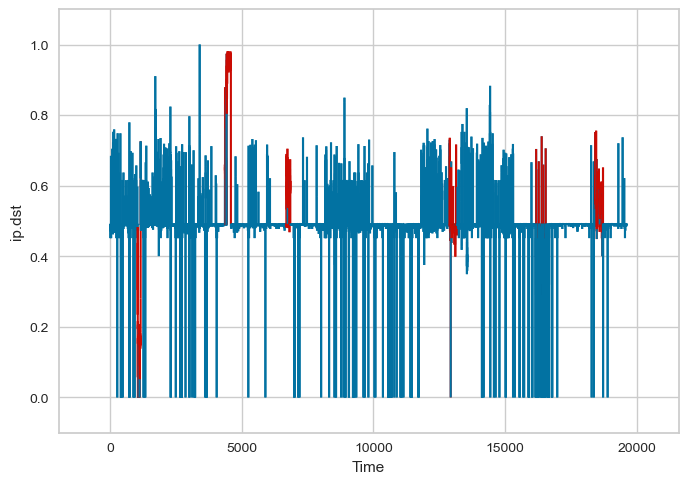

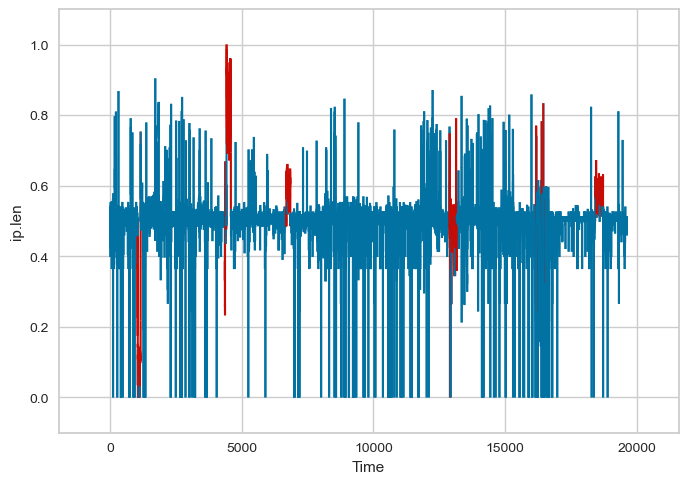

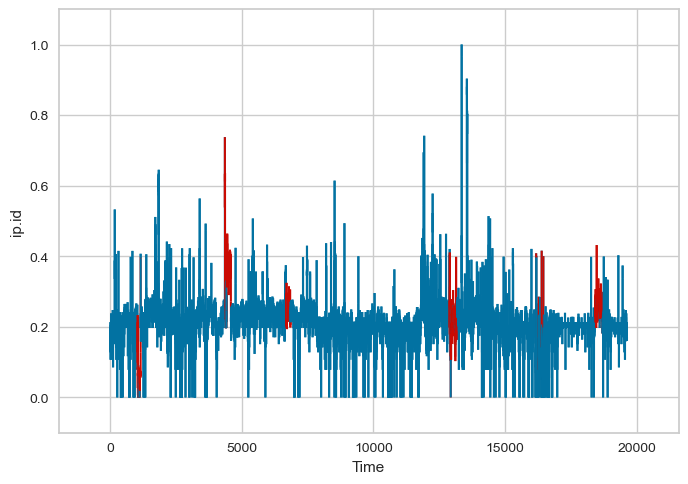

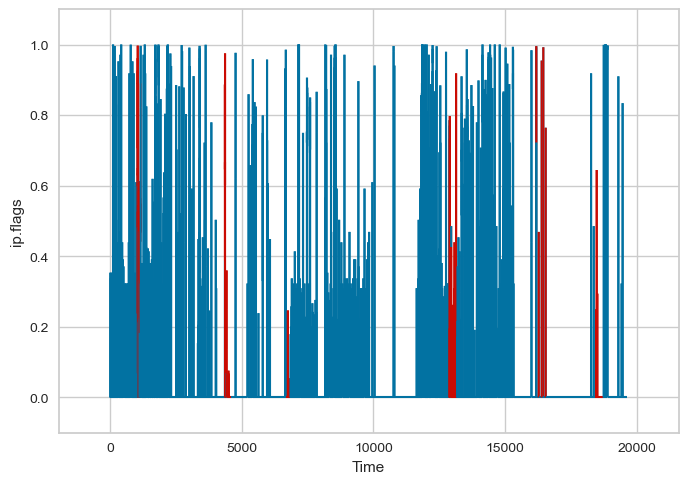

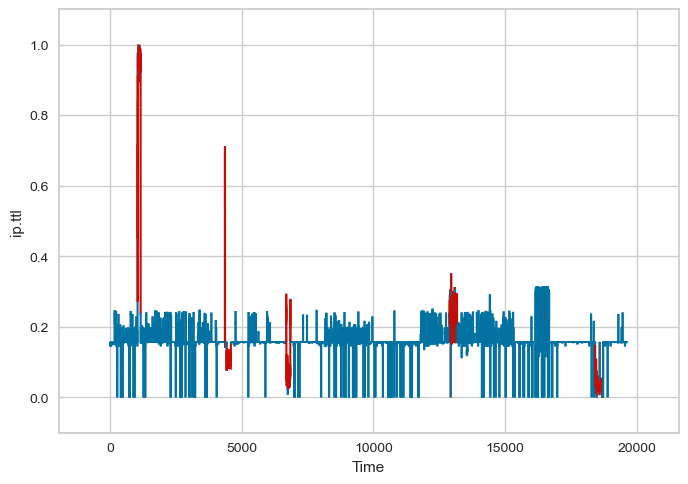

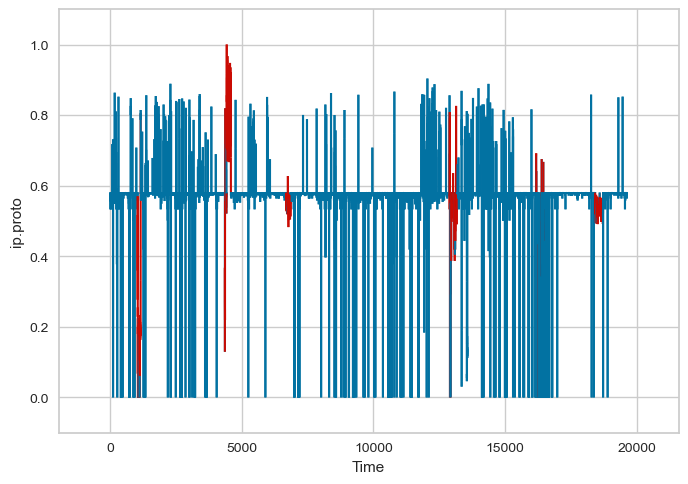

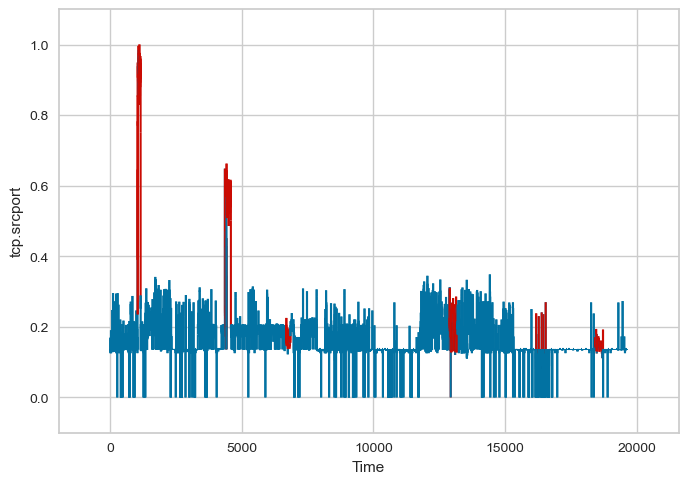

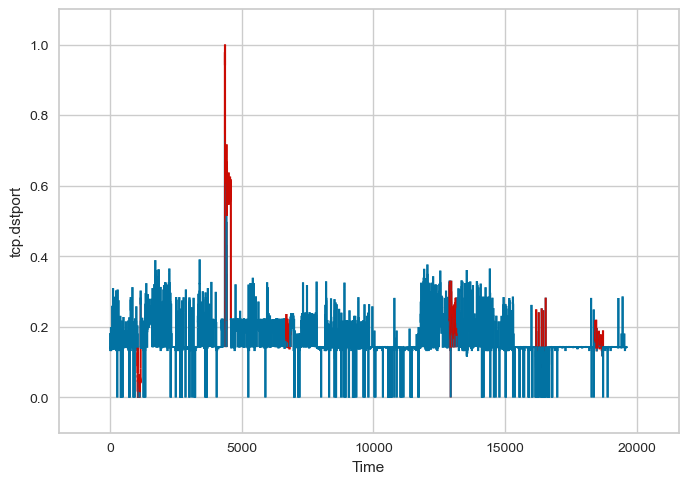

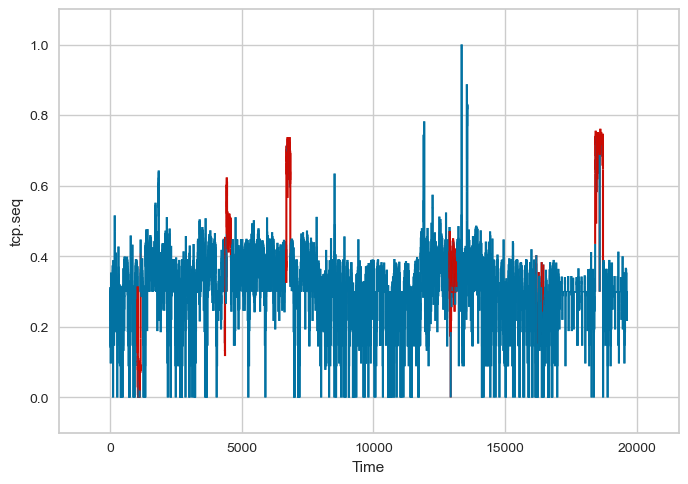

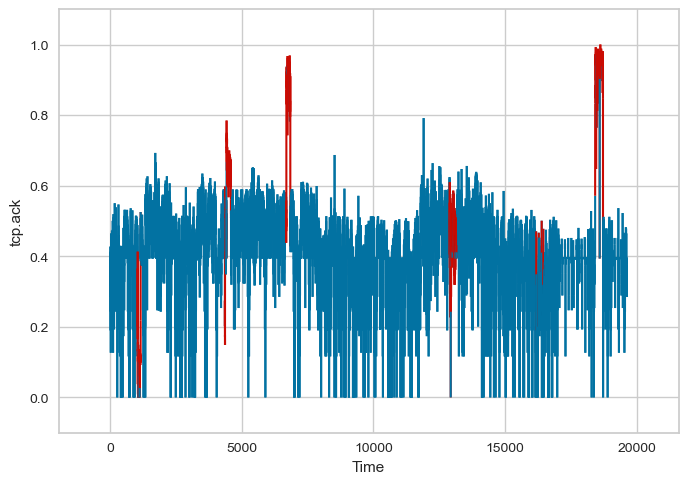

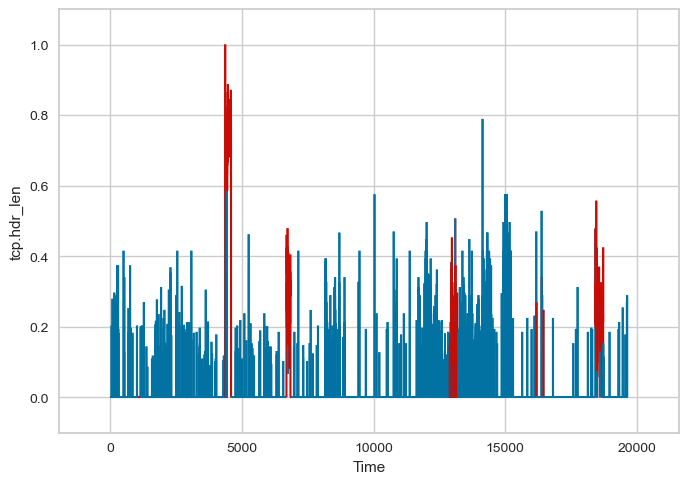

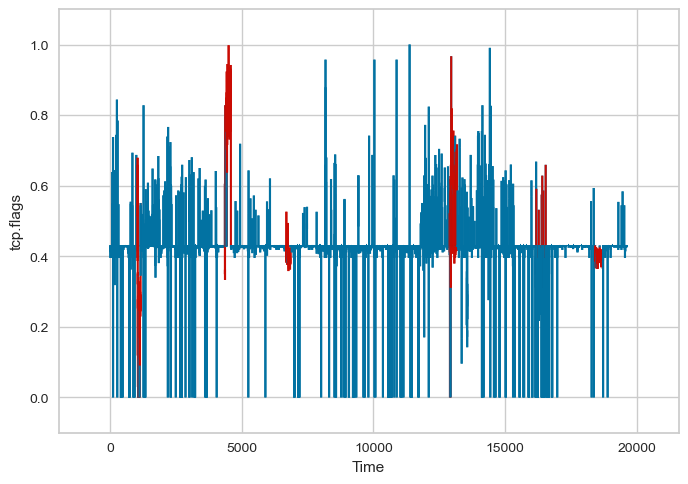

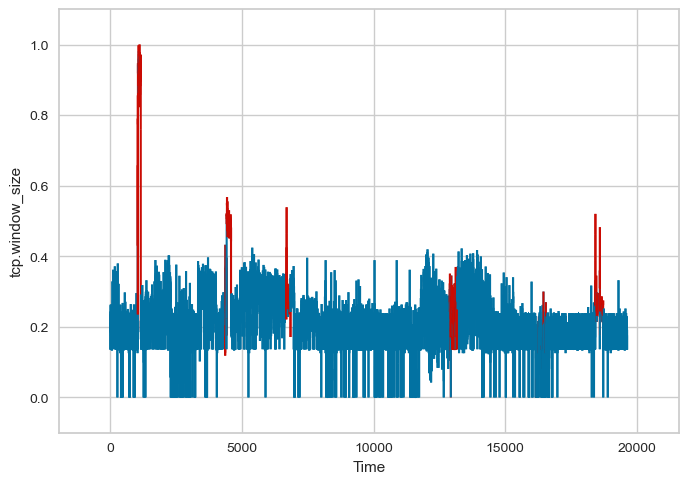

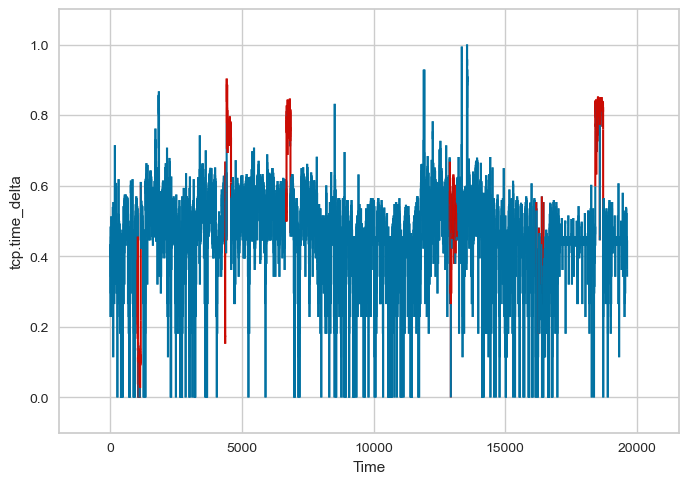

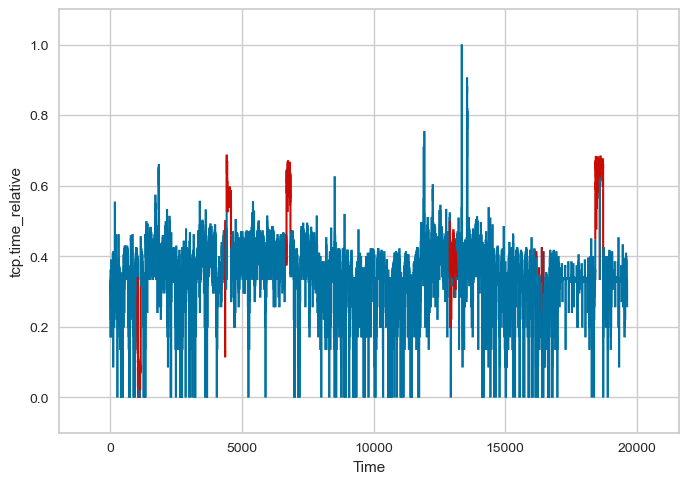

In [95]:
for i in range(1,19):
    x = ics_entropy[:,0]
    y = ics_entropy[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,attack_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [ ]:
for i in range(1,18):
    x = range(smooth_ics.shape[0])
    y = smooth_ics[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,attack_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [47]:
X = pd.DataFrame(np.concatenate((ics_entropy,np.delete(attack_entropy,0,1)),axis=1))
# X = pd.DataFrame(ics_entropy)
X.columns = list(col)+['attack']
setup(X,session_id=123)
# setup(X,target='attack',fix_imbalance = True,feature_selection=True)

('lightgbm',
 {'abod': <pycaret.containers.models.anomaly.ABODAnomalyContainer at 0x7fe737900550>,
  'cluster': <pycaret.containers.models.anomaly.CBLOFAnomalyContainer at 0x7fe737900820>,
  'cof': <pycaret.containers.models.anomaly.COFAnomalyContainer at 0x7fe72b8b2670>,
  'iforest': <pycaret.containers.models.anomaly.IForestAnomalyContainer at 0x7fe729fb8850>,
  'histogram': <pycaret.containers.models.anomaly.HBOSAnomalyContainer at 0x7fe72b8a6340>,
  'knn': <pycaret.containers.models.anomaly.KNNAnomalyContainer at 0x7fe72af64400>,
  'lof': <pycaret.containers.models.anomaly.LOFAnomalyContainer at 0x7fe72af64eb0>,
  'svm': <pycaret.containers.models.anomaly.OCSVMAnomalyContainer at 0x7fe72af643d0>,
  'pca': <pycaret.containers.models.anomaly.PCAAnomalyContainer at 0x7fe72bc84e50>,
  'mcd': <pycaret.containers.models.anomaly.MCDAnomalyContainer at 0x7fe72bc842b0>,
  'sod': <pycaret.containers.models.anomaly.SODAnomalyContainer at 0x7fe72bc84d00>,
  'sos': <pycaret.containers.models.an

In [12]:
models()
# model = compare_models()

Name                    Reference
ID                                                                       
abod            Angle-base Outlier Detection        pyod.models.abod.ABOD
cluster       Clustering-Based Local Outlier      pyod.models.cblof.CBLOF
cof         Connectivity-Based Local Outlier          pyod.models.cof.COF
iforest                     Isolation Forest  pyod.models.iforest.IForest
histogram  Histogram-based Outlier Detection        pyod.models.hbos.HBOS
knn             K-Nearest Neighbors Detector          pyod.models.knn.KNN
lof                     Local Outlier Factor          pyod.models.lof.LOF
svm                   One-class SVM detector      pyod.models.ocsvm.OCSVM
pca             Principal Component Analysis          pyod.models.pca.PCA
mcd           Minimum Covariance Determinant          pyod.models.mcd.MCD
sod               Subspace Outlier Detection          pyod.models.sod.SOD
sos             Stochastic Outlier Selection          pyod.models.sos.SOS

In [ ]:
cluster = create_model('cluster', fraction = 0.09)
cluster_result = assign_model(cluster)
anomaly = cluster_result['Anomaly']
anomaly.to_csv('ics_anomaly_value.csv', index=False)
pd.DataFrame(attack_entropy[:,1]).to_csv('ics_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(19633):
    if i not in attack_time and anomaly[i]==0:
        TN += 1
    elif i in attack_time and anomaly[i]==1:
        TP += 1
    elif i in attack_time and anomaly[i]==0:
        FN += 1
    elif i not in attack_time and anomaly[i]==1:
        FP += 1

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python

/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python

/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python

In [18]:
plot_model(cluster)

In [32]:
tuned_cluster = tune_model(cluster,supervised_target = 'attack')

In [33]:
svm = create_model('svm', fraction = 0.06)
svm_result = assign_model(svm)
anomaly = svm_result['Anomaly']
# anomaly.to_csv('ics_anomaly_value.csv', index=False)
# pd.DataFrame(attack_entropy[:,1]).to_csv('ics_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(19633):
    if i not in attack_time and anomaly[i]==0:
        TN += 1
    elif i in attack_time and anomaly[i]==1:
        TP += 1
    elif i in attack_time and anomaly[i]==0:
        FN += 1
    elif i not in attack_time and anomaly[i]==1:
        FP += 1

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

True positive = 724
False positive = 454
True negative = 18170
False negative = 285


In [34]:
feature_bagging = create_model('feature_bagging', fraction = 0.05)
feature_bagging_result = assign_model(feature_bagging)
anomaly = feature_bagging_result['Anomaly']
# anomaly.to_csv('ics_anomaly_value.csv', index=False)
# pd.DataFrame(attack_entropy[:,1]).to_csv('ics_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(19633):
    if i not in attack_time and anomaly[i]==0:
        TN += 1
    elif i in attack_time and anomaly[i]==1:
        TP += 1
    elif i in attack_time and anomaly[i]==0:
        FN += 1
    elif i not in attack_time and anomaly[i]==1:
        FP += 1

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

ValueError: Estimator feature_bagging not available. Please see docstring for list of available estimators.